<a href="https://colab.research.google.com/github/riye-das/Plant_disease_detection/blob/main/Plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"witcher690","key":"5de60018bbf15d2ce8d6b9b1f8974df7"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          31355        853  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           3473         96  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5754        120  1.0              
mohithsairamreddy/salary-data 

In [ ]:
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

 99% 2.67G/2.70G [00:31<00:00, 107MB/s] 
100% 2.70G/2.70G [00:31<00:00, 92.0MB/s]


In [ ]:
! unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

Starting

In [ ]:
# Dowload the packages
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Dowload the packages
import numpy as np
import pandas as pd
import os,os.path
import splitfolders
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

import keras.backend as K
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
# Set some default variables
DATA_DIR = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
BATCH_SIZE = 40
EPOCHS = 6
IMAGE_SHAPE = (224, 224)

In [ ]:
def f1_macro(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Check the content

pairs = list()
number = list()

for directory in os.listdir(path=DATA_DIR):
    columns = directory.split('___')
    columns.append(directory)

    sub_path = DATA_DIR + '/' + directory
    columns.append(len([name for name in os.listdir(path=sub_path)]))

    pairs.append(columns)

pairs = pd.DataFrame(pairs, columns=['Plant', 'Disease', 'Directory', 'Files'])
pairs.sort_values(by='Plant')

,Plant,Disease,Directory,Files
35,Apple,healthy,Apple___healthy,2008
2,Apple,Cedar_apple_rust,Apple___Cedar_apple_rust,1760
27,Apple,Apple_scab,Apple___Apple_scab,2016
26,Apple,Black_rot,Apple___Black_rot,1987
36,Blueberry,healthy,Blueberry___healthy,1816
33,Cherry_(including_sour),healthy,Cherry_(including_sour)___healthy,1826
32,Cherry_(including_sour),Powdery_mildew,Cherry_(including_sour)___Powdery_mildew,1683
37,Corn_(maize),healthy,Corn_(maize)___healthy,1859
29,Corn_(maize),Northern_Leaf_Blight,Corn_(maize)___Northern_Leaf_Blight,1908
8,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,1642


In [ ]:
# Save the directories to be deleted
rows_to_drop = [17, 3, 33, 4, 5]
dir_to_delete = pairs[pairs.index.isin(rows_to_drop)]['Directory']
print(dir_to_delete.values)

['Tomato___Septoria_leaf_spot' 'Raspberry___healthy' 'Soybean___healthy'
 'Tomato___Leaf_Mold' 'Cherry_(including_sour)___healthy']


In [ ]:
# Make a directory images
os.mkdir('images')

# Make subdirectories train, val, test
os.mkdir(os.path.join('images', 'train'))
os.mkdir(os.path.join('images', 'val'))
os.mkdir(os.path.join('images', 'test'))

In [ ]:
# Split the data into folders
splitfolders.ratio(DATA_DIR,output = "images",seed = 42,ratio = (0.80,0.10,0.10))

Copying files: 70295 files [00:26, 2613.42 files/s]


In [ ]:
# Remove the directories we saved before

TRAIN_PATH = "./images/train"
VAL_PATH = "./images/val"
TEST_PATH  = "./images/test"
PATHS = [TRAIN_PATH, VAL_PATH, TEST_PATH]

for sub_directory in dir_to_delete.values:
    for directory in PATHS:
        d = directory + '/' + sub_directory
        shutil.rmtree(d)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH,
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

test_gen = datagen.flow_from_directory(directory = TEST_PATH,
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          shuffle = False)

Found 48817 images belonging to 33 classes.
Found 6089 images belonging to 33 classes.
Found 6133 images belonging to 33 classes.


In [ ]:
# Make a directory for models
os.mkdir('models')

# Make subdirectories train, val, test
os.mkdir(os.path.join('models', 'first_version'))

In [ ]:
# Here we create checkpoint for the first model
CHECKPOINT_PATH_MODEL_FIRST = "./models/first_version"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH_MODEL_FIRST,
                                      monitor='val_loss',
                                      save_best_only=True)

In [ ]:
# Set early stopping for 2 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, restore_best_weights=True)

In [ ]:
# Here MobileNet pretrained model is downloaded; We do not include the last dense layers by setting include_top parameter to False
mobilenet_augm_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# We fix the parameters of the pretrained model
mobilenet_augm_model.trainable = False

In [ ]:
# Add data augmentation layers
augmentation = tf.keras.Sequential([
   tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
   tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
   tf.keras.layers.experimental.preprocessing.RandomContrast(0.15),
])

In [ ]:
# Here we add final layers to the first model
inputs = mobilenet_augm_model.input
x = augmentation(inputs)

x = BatchNormalization()(mobilenet_augm_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.45, seed=1234)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45, seed=1235)(x)
x = Flatten()(x)

outputs = Dense(33, activation='softmax')(x)

mobilenet_augm_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Here we check if everything is okay with the model
mobilenet_augm_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=[f1_macro]
)

In [ ]:
# Here we fit the model
history = mobilenet_augm_model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/6
  89/1221 [=>............................] - ETA: 32:32 - loss: 3.3057 - f1_macro: 0.0668

KeyboardInterrupt: ignored

In [ ]:
results = mobilenet_augm_model.evaluate(test_gen, verbose=1)

154/154 [==============================] - 17s 110ms/step - loss: 0.1208 - f1_macro: 0.9585


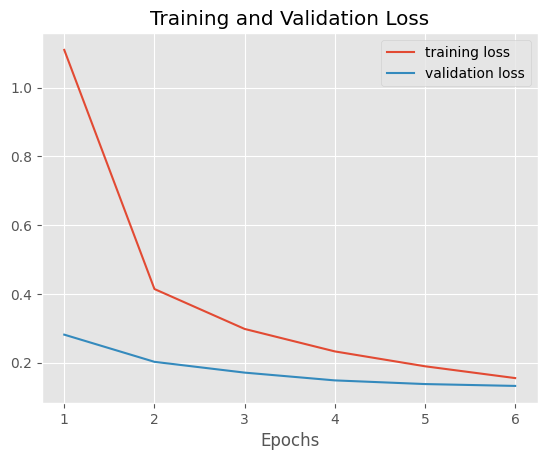

In [ ]:
# Here we make the first plot for Loss
Epochs = [i+1 for i in range(len(history.history['f1_macro']))]

plt.plot(Epochs, history.history['loss'], label = 'training loss')
plt.plot(Epochs, history.history['val_loss'], label = 'validation loss')
plt.grid(True)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

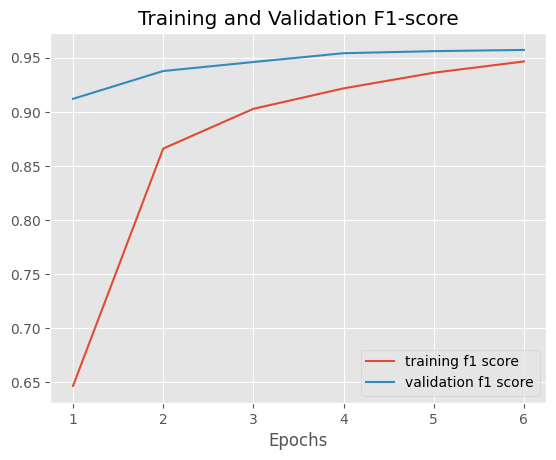

In [ ]:
# Here we make the first plot for F1-score
Epochs = [i+1 for i in range(len(history.history['f1_macro']))]

plt.plot(Epochs, history.history['f1_macro'], label = 'training f1 score')
plt.plot(Epochs, history.history['val_f1_macro'], label = 'validation f1 score')
plt.grid(True)
plt.legend()
plt.title('Training and Validation F1-score')
plt.xlabel('Epochs')
plt.show()

Saving septoria-spot-tomato-plant-ea2ab44d-e6f21d609dd04b2f96d96a33e98aab07.jpg to septoria-spot-tomato-plant-ea2ab44d-e6f21d609dd04b2f96d96a33e98aab07 (6).jpg
1/1 [==============================] - 1s 879ms/step
The picture has a disease: Tomato___Bacterial_spot


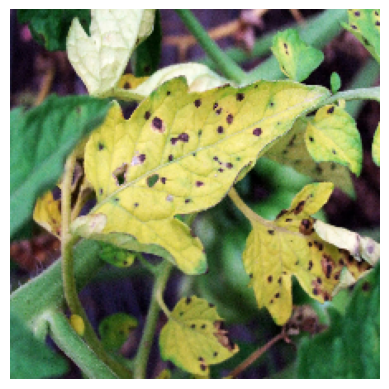

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model

# Upload the image
uploaded = files.upload()

# Load the trained model
model = load_model(CHECKPOINT_PATH_MODEL_FIRST, custom_objects={'f1_macro': f1_macro})

# Define the disease labels
disease_labels = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
                  'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew',
                  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust',
                  'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot',
                  'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
                  'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy',
                  'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight',
                  'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy',
                  'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch',
                  'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight',
                  'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite']

# Process the uploaded image
for filename in uploaded.keys():
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SHAPE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make the prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    disease = disease_labels[predicted_class]
    print("The picture has a disease:", disease)

    plt.imshow(img[0])
    plt.axis('off')
    plt.show()

